### Table of Content
- [`passivating_molecule` into SMILES format](Converting-`passivating_molecule`-into-SMILES-format)
- [`perovskite_composition` into features](`perovskite_composition`-into-features)
- [baseline ML model](baseline-ML-model)

In [1]:
import pandas as pd
import numpy as np
import pubchempy as pcp

In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

In [3]:
df = pd.read_json('data/finetuned_llama_output.json')
data = df.T.sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 0 to 149
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   control_pce               71 non-null     object
 1   control_voc               53 non-null     object
 2   treated_pce               140 non-null    object
 3   treated_voc               124 non-null    object
 4   passivating_molecule      143 non-null    object
 5   perovskite_composition    134 non-null    object
 6   electron_transport_layer  118 non-null    object
 7   hole_transport_layer      115 non-null    object
 8   pin_nip_structure         147 non-null    object
 9   stability_tests           149 non-null    object
 10  pin_structure             1 non-null      object
dtypes: object(11)
memory usage: 14.0+ KB


In [5]:
# Function to select columns
def select_data(df):
    # Convert PCE and VOC to numeric
    for col in ['control_pce', 'control_voc', 'treated_pce', 'treated_voc']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows where treated_pce or passivating_molecule is missing
    df = df.dropna(subset=['treated_pce', 'passivating_molecule', 'perovskite_composition'])

    return df

data = select_data(data)
data.head()

,control_pce,control_voc,treated_pce,treated_voc,passivating_molecule,perovskite_composition,electron_transport_layer,hole_transport_layer,pin_nip_structure,stability_tests,pin_structure
0,25.7,1.17,26.15,1.18,4-chlorobenzenesulfonate (4Cl-BZS),α-phase FAPbI3,C60,SAMs (self-assembled monolayers),PIN,"[{'test_name': 'ISOS-D-2I', 'temperature': 85,...",NaN
3,24.5,1.20,24.50,1.20,BA2MA2Pb3I10,BA2MA2Pb3I10,SnO2,PTAA,PIN,"[{'test_name': 'ISOS-L-1', 'temperature': None...",NaN
4,NaN,NaN,21.06,1.14,vinylbenzylammonium bromide (VBABr),(FAPbI3)0.95(MAPbBr3)0.05,Spiro-OMeTAD,Spiro-OMeTAD,PIN,"[{'test_name': None, 'temperature': None, 'tim...",NaN
5,NaN,NaN,22.10,1135.00,iso-BAI,FA(MA)PbI3,Spiro-OMeTAD,TPBI,PIN,"[{'test_name': 'ISOS-LT', 'temperature': None,...",NaN
6,NaN,NaN,15.30,1.06,phenylethylammonium,PEA2(CH3NH3)n-1Pb(nI3n+1),TiO2,spiro-OMeTAD,PIN,"[{'test_name': 'ISOS-D', 'temperature': None, ...",NaN


In [9]:
data.isna().sum(axis=0)

control_pce                  59
control_voc                  73
treated_pce                   0
treated_voc                  10
passivating_molecule          0
perovskite_composition        0
electron_transport_layer     19
hole_transport_layer         20
pin_nip_structure             0
stability_tests               0
pin_structure               107
dtype: int64

## `passivating_molecule` into SMILES format

In [12]:
def fetch_smiles_from_name(molecule_name):
    try:
        # Search for the molecule in PubChem by name
        compounds = pcp.get_compounds(molecule_name, 'name')
        if compounds:
            return compounds[0].isomeric_smiles  # Return the first match's SMILES
        else:
            return np.nan
    except Exception as e:
        print(f"Error fetching SMILES for {molecule_name}: {e}")
        return None

In [14]:
data['passivating_molecule']

0                     4-chlorobenzenesulfonate (4Cl-BZS)
3                                           BA2MA2Pb3I10
4                    vinylbenzylammonium bromide (VBABr)
5                                                iso-BAI
6                                    phenylethylammonium
                             ...                        
144                                               GlyHCl
145                                4-fluoroaniline (FAL)
147    4-(3,6-bis(4-(bis(4-methoxyphenyl)amino)phenyl...
148           4-tert-butyl-benzylammonium iodide (tBBAI)
149            4-trifluoromethyl-phenylammonium (CF3-PA)
Name: passivating_molecule, Length: 107, dtype: object

### Cleaning Data

In [17]:
import re

def fix_unmatched_brackets(s):
    """
    Fixes unmatched brackets in the given string by adding the correct brackets where necessary.

    :param s: Input string with potential unmatched brackets.
    :return: A corrected string with properly balanced brackets.
    """
    opening = "({["
    closing = ")}]"
    match = {')': '(', '}': '{', ']': '['}
    stack = []

    # Step 1: Identify missing closing brackets
    fixed_s = []
    for char in s:
        if char in opening:
            stack.append(char)
            fixed_s.append(char)
        elif char in closing:
            if stack and stack[-1] == match[char]:
                stack.pop()
                fixed_s.append(char)
            else:
                # Add missing opening bracket before unmatched closing
                fixed_s.insert(0, match[char])
                fixed_s.append(char)
        else:
            fixed_s.append(char)

    # Step 2: Add missing closing brackets at the end
    while stack:
        open_bracket = stack.pop()
        fixed_s.append(closing[opening.index(open_bracket)])

    return "".join(fixed_s)


def get_chemical_names(chemical_list):
    cleaned_list = []
    for name in chemical_list:
        # Remove text inside parentheses only if it's extra information (abbreviations)
        name = re.sub(r"\s*\([^)]*\)$", "", name).strip() 
        # Remove spaces after a closing bracket (ensure proper chemical formatting)
        name = re.sub(r"\] +", "]", name)

        cleaned_list.append(name)

    return cleaned_list

In [19]:
# Example input list
lst = data['passivating_molecule']

# Cleaning the list
cleaned_list = lst.apply(lambda x: fix_unmatched_brackets(x))
cleaned_list = get_chemical_names(cleaned_list)

# Output result
data['passivating_molecule_cleaned'] = cleaned_list

In [21]:
data['passivating_molecule_SMILES'] = data['passivating_molecule_cleaned'].apply(fetch_smiles_from_name)

In [22]:
data['passivating_molecule_SMILES'].isna().sum()

64

In [23]:
# temporary smaller data with all SMILES
temp_data = data[~data['passivating_molecule_SMILES'].isna()]

In [24]:
temp_data.isna().sum()

control_pce                     23
control_voc                     30
treated_pce                      0
treated_voc                      4
passivating_molecule             0
perovskite_composition           0
electron_transport_layer         8
hole_transport_layer             8
pin_nip_structure                0
stability_tests                  0
pin_structure                   43
passivating_molecule_cleaned     0
passivating_molecule_SMILES      0
dtype: int64

## `perovskite_composition` into features

In [29]:
import chemparse

# Example formula
formula = "(FAPbI3)0.95(MAPbBr3)0.05"

# Parse formula
result = chemparse.parse_formula(formula)
print(result)  # Output: {'FA': 0.95, 'Pb': 1.0, 'I': 2.85, 'MA': 0.05, 'Br': 0.15}

{'Br': 0.15000000000000002, 'Pb': 1.0, 'M': 0.05, 'A': 1.0, 'I': 2.8499999999999996, 'F': 0.95}


In [31]:
temp_data['perovskite_composition_'] = temp_data['perovskite_composition'].apply(chemparse.parse_formula)

/var/folders/_c/tmnx15c54v7cn_b4tx022flc0000gn/T/ipykernel_96676/2848759358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['perovskite_composition_'] = temp_data['perovskite_composition'].apply(chemparse.parse_formula)


In [33]:
print(len(temp_data))  # Should be 43

43


## some molecular features

In [35]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

def compute_molecular_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return [
                Descriptors.MolWt(mol),  # Molecular weight
                Descriptors.ExactMolWt(mol),  # Exact molecular weight (isotope-specific)
                Descriptors.MolLogP(mol),  # LogP (lipophilicity)
                Descriptors.TPSA(mol),  # Topological Polar Surface Area
                Descriptors.NumValenceElectrons(mol),  # Total valence electrons
                rdMolDescriptors.CalcNumRotatableBonds(mol),  # Rotatable bonds
                rdMolDescriptors.CalcNumHBA(mol),  # Hydrogen bond acceptors
                rdMolDescriptors.CalcNumHBD(mol),  # Hydrogen bond donors
                rdMolDescriptors.CalcFractionCSP3(mol),  # Fraction of sp3 carbons
                rdMolDescriptors.CalcNumAromaticRings(mol),  # Number of aromatic rings
                rdMolDescriptors.CalcNumSaturatedRings(mol),  # Number of saturated rings
                rdMolDescriptors.CalcNumHeteroatoms(mol),  # Number of heteroatoms
                rdMolDescriptors.CalcNumHeavyAtoms(mol),  # Number of heavy atoms
                rdMolDescriptors.CalcNumSpiroAtoms(mol),  # Number of spiro atoms
                rdMolDescriptors.CalcNumBridgeheadAtoms(mol),  # Number of bridgehead atoms
                Descriptors.FpDensityMorgan1(mol),  # Morgan fingerprint density (radius=1)
                Descriptors.FpDensityMorgan2(mol),  # Morgan fingerprint density (radius=2)
                Descriptors.FpDensityMorgan3(mol),  # Morgan fingerprint density (radius=3)
                Descriptors.qed(mol),  # Quantitative Estimate of Drug-likeness
                rdMolDescriptors.CalcNumLipinskiHBA(mol),  # Lipinski Hydrogen Bond Acceptors
                rdMolDescriptors.CalcNumLipinskiHBD(mol),  # Lipinski Hydrogen Bond Donors
                rdMolDescriptors.CalcNumRings(mol),  # Total number of rings
                rdMolDescriptors.CalcNumAmideBonds(mol),  # Number of amide bonds
                Descriptors.BalabanJ(mol),  # Balaban’s connectivity index
                Descriptors.BertzCT(mol),  # Bertz complexity
                Descriptors.Chi0(mol),  # Chi connectivity index (order 0)
                Descriptors.Chi1(mol),  # Chi connectivity index (order 1)
                Descriptors.Chi2n(mol),  # Chi connectivity index (order 2, non-H)
                Descriptors.Kappa1(mol),  # Kappa Shape Index (order 1)
                Descriptors.Kappa2(mol),  # Kappa Shape Index (order 2)
            ]
        else:
            return [np.nan] * 30  # Return NaN for missing values
    except:
        return [np.nan] * 30  # Return NaN for exceptions

# Apply function to dataset
mol_features = temp_data['passivating_molecule_SMILES'].apply(compute_molecular_features)

# Convert list to DataFrame
mol_features_df = pd.DataFrame(mol_features.tolist(), 
                               columns=[
                                   'MolWt', 'ExactMolWt', 'LogP', 'TPSA', 'NumValenceElectrons',
                                   'NumRotBonds', 'NumHBA', 'NumHBD', 'FractionCSP3', 'AromaticRings',
                                   'SaturatedRings', 'Heteroatoms', 'HeavyAtoms', 'SpiroAtoms', 
                                   'BridgeheadAtoms', 'FpDensityMorgan1', 'FpDensityMorgan2', 
                                   'FpDensityMorgan3', 'QED', 'LipinskiHBA', 
                                   'LipinskiHBD', 'NumRings', 'NumAmideBonds', 'BalabanJ', 
                                   'BertzCT', 'Chi0', 'Chi1', 'Chi2n', 'Kappa1', 'Kappa2'
                               ],
                               index=temp_data.index)

# Merge with original dataset
temp_data = pd.concat([temp_data, mol_features_df], axis=1)

In [41]:
temp_data.shape

(43, 44)

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming `temp_data` contains the full dataset with the required columns
features = [
                                   'MolWt', 'ExactMolWt', 'LogP', 'TPSA', 'NumValenceElectrons',
                                   'NumRotBonds', 'NumHBA', 'NumHBD', 'FractionCSP3', 'AromaticRings',
                                   'SaturatedRings', 'Heteroatoms', 'HeavyAtoms', 'SpiroAtoms', 
                                   'BridgeheadAtoms', 'FpDensityMorgan1', 'FpDensityMorgan2', 
                                   'FpDensityMorgan3', 'QED', 'LipinskiHBA', 
                                   'LipinskiHBD', 'NumRings', 'NumAmideBonds', 'BalabanJ', 
                                   'BertzCT', 'Chi0', 'Chi1', 'Chi2n', 'Kappa1', 'Kappa2'
                               ]
target = 'treated_pce'

# Drop rows with missing values in the features or target
data = temp_data

# Split into features (X) and target (y)
X = data[features]
y = data[target]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a Random Forest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse:.2f}")
print(f"Training R-squared: {train_r2:.2f}")
print(f"Testing Mean Squared Error: {test_mse:.2f}")
print(f"Testing R-squared: {test_r2:.2f}")

Training Mean Squared Error: 1.78
Training R-squared: 0.80
Testing Mean Squared Error: 3.36
Testing R-squared: -0.12


In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred = linear_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error (MSE): 2874.09
R-squared: -952.35


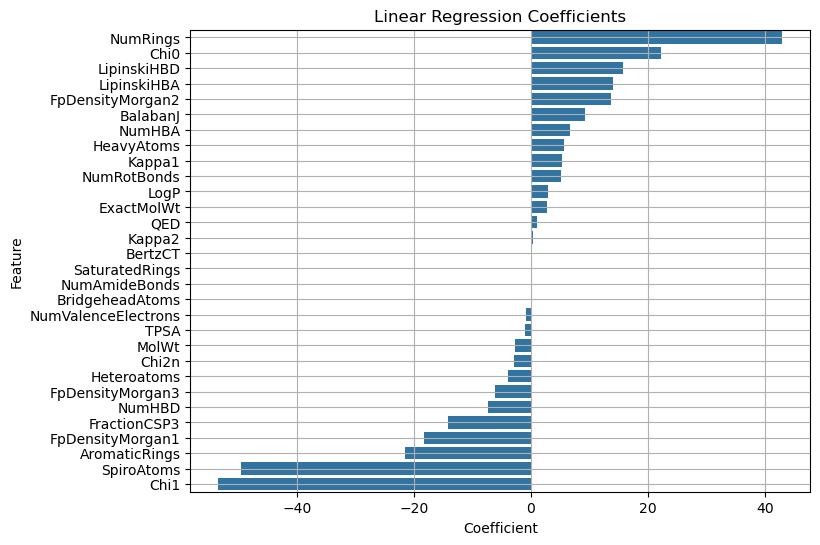

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': linear_model.coef_
})

plt.figure(figsize=(8, 6))
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression Coefficients')
plt.grid(True)
plt.show()